# Example processing of AJILE dataset
This notebook runs through loading the data and some simple preprocessing.

Author: Kameron Decker Harris

### Loading the data
First, we use pyedflib to open a handle to a specific dataset.

In [1]:
%matplotlib notebook

import pyedflib
import numpy as np
import matplotlib.pyplot as plt

# Change the below to point to where you downloaded AJILE
data_dir = '/home/kamdh/data'
# patient_code = "c95c1e82"
# day = 8
patient_code = 'cb46fd46'
day = 4
signal_channel = 52
ecog_fn = data_dir + "/purged_" + patient_code + "_day_" + str(day) + ".edf"
f = pyedflib.EdfReader(ecog_fn) # open the file

The EdfReader class provides a number of methods to access information about each recording.
For instance, we can see what kind of channel this is:

In [2]:
f.signal_label(signal_channel)

b'GRID53          '

"GRID" means an electrode in our ECoG array. We can also get the sample frequency in Hz:

In [3]:
f.samplefrequency(signal_channel)

1000.0

We can then read a that channel into a numpy array:

In [4]:
ecog_data = f.readSignal(signal_channel)
ecog_data

array([  2.47126482e+03,   2.46382135e+03,   2.46222633e+03, ...,
         3.50000000e-02,   3.50000000e-02,   3.50000000e-02])

Now lets load the movement data stored as CSV that accompany this ECoG recording. For this, we will use the pandas package. Each join movement is stored as a tuple in the corresponding CSV column, but we will split these into separate columns in our pandas data frame for easy access later.

All of this parsing makes this step slow.

In [5]:
import pandas as pd
import ast

mvmt_fn = data_dir + "/" + patient_code + "_day_" + str(day) + ".csv"

# This parse is used to split the (x, y, confidence) tuples
parser = ast.literal_eval # safe eval

# Read CSV and parse tuple strings
# These are stored in a single column, but as python tuples.
mvmt_df = pd.read_csv(mvmt_fn, \
                   converters={"head": parser,\
                               "r_shoulder": parser,\
                               "l_shoulder": parser,\
                               "r_elbow": parser,\
                               "l_elbow": parser,\
                               "r_wrist": parser,\
                               "l_wrist": parser})

# Time data are easier to use if parsed into datetime format.
# Convert time column into timedelta type, then add the start time.
# Making time absolute leads to better plotting later.
mvmt_df['time'] = pd.to_timedelta(mvmt_df['time']) + f.getStartdatetime()

# Below now splits each tuple into x, y, and confidence
# which are stored in their own columns.
# Example: "head" becomes "head_x", "head_y", and "head_conf"
old_col_list = ['head', 'r_shoulder', 'l_shoulder', 'r_elbow', 'l_elbow', 'r_wrist', 'l_wrist']
for old_col in old_col_list:
    new_col_append = ['x', 'y', 'conf'] # every movement variable stored this way
    for n, col_append in enumerate(new_col_append):
        col = old_col + '_' + col_append
        mvmt_df[col] = mvmt_df[old_col].apply(lambda entry: entry[n])
    mvmt_df = mvmt_df.drop(old_col, axis=1)
# Now our dataframe mvmt_df contains 3 columns for each of these variables
mvmt_df.head()

,Unnamed: 0,time,missing,purged,head_x,head_y,head_conf,r_shoulder_x,r_shoulder_y,r_shoulder_conf,...,r_elbow_conf,l_elbow_x,l_elbow_y,l_elbow_conf,r_wrist_x,r_wrist_y,r_wrist_conf,l_wrist_x,l_wrist_y,l_wrist_conf
0,0,2000-01-04 00:00:00.000000,0,0,212.328125,180.269531,0.714857,159.453125,312.398438,0.036450,...,0.144297,365.445312,215.503906,0.008034,203.515625,215.503906,0.176093,313.671875,183.472656,0.020772
1,1,2000-01-04 00:00:00.033325,0,0,212.328125,180.269531,0.730907,159.453125,312.398438,0.038572,...,0.149416,362.140625,215.503906,0.009940,203.515625,216.304688,0.183443,318.078125,181.070312,0.021358
2,2,2000-01-04 00:00:00.066650,0,0,212.328125,180.269531,0.739852,159.453125,312.398438,0.044453,...,0.181382,181.484375,277.164062,0.009659,203.515625,216.304688,0.179560,318.078125,181.070312,0.016193
3,3,2000-01-04 00:00:00.099975,0,0,212.328125,180.269531,0.726452,159.453125,312.398438,0.051899,...,0.153545,365.445312,215.503906,0.010798,203.515625,215.503906,0.153631,313.671875,183.472656,0.014435
4,4,2000-01-04 00:00:00.133300,0,0,212.328125,180.269531,0.721652,159.453125,312.398438,0.048714,...,0.146459,365.445312,215.503906,0.010965,206.820312,215.503906,0.163258,313.671875,183.472656,0.026449


Now we will create an array of times for the ECoG data.

In [6]:
times = pd.timedelta_range(0, periods=len(ecog_data), freq='L') # L means ms
times = times + f.getStartdatetime() # making time absolute leads to better plotting

### Standardization & plotting
Now that we have our data stored in a nice array and dataframe, let's process it and produce a few plots.

One of the first things you might do with this kind of timeseries data is standardize to mean zero, variance one.
We'll standardize the ecog_data array as well as the head movements x and y, and create a mask that tells us where head position confidence is greater than 0.25.

In [7]:
def standardize(data):
    return (data - data.mean())/data.std()

body_part = 'head'
y1 = standardize(ecog_data)
y2 = standardize(mvmt_df[body_part + '_x'])
y3 = standardize(mvmt_df[body_part + '_y'])

y_conf_mask = mvmt_df[body_part + '_conf'] > 0.25

Now plot the timeseries. You can zoom and pan in the notebook.

<IPython.core.display.Javascript object>


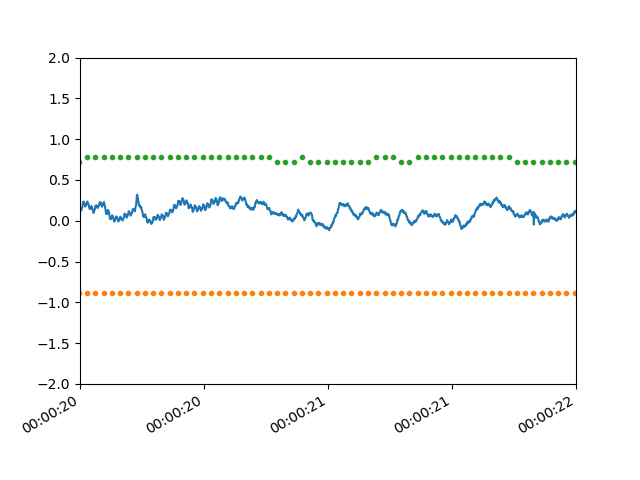

(-2, 2)

In [8]:
fig, ax = plt.subplots(1)
ax.plot(times, y1)
ax.plot(mvmt_df['time'][y_conf_mask], y2[y_conf_mask], '.')
ax.plot(mvmt_df['time'][y_conf_mask], y3[y_conf_mask], '.')
# rotate and align the tick labels so they look better
fig.autofmt_xdate()
plt.xlim([times[20*1000], times[22*1000]])
plt.ylim([-2,2])

### Filtering noise

Now, let's perform some more involved analysis. 
The ECoG data are sampled at 1 kHz, but a lot of the high frequency activity is noise. 
Furthermore, the electrode potential can drift slowly, and there is 60 Hz line noise plus harmonics.
We'll thus use a bandpass filter to get the overall range and then bandstops at 60, 120, ..., 240 Hz.

In [9]:
from scipy import signal
f_sample = f.samplefrequency(signal_channel) # = 1000 Hz
f_Ny = f_sample / 2. # Nyquist frequency
f_high = 200.        # bandpass max frequency in Hz
f_low = 0.5          # bandpass min frequency in Hz
# 1) bandpass filter
b, a = signal.butter(4, [f_low / f_Ny, f_high / f_Ny], 'band')
y = signal.filtfilt(b, a, y1)
# 2) bandstop filter, 60 Hz line noise and harmonics
for mult in [1, 2, 3, 4]:
    f_stop_mid = 60. * mult
    f_stop = np.array([f_stop_mid - 0.5, f_stop_mid + 0.5])
    b, a = signal.butter(4, f_stop / f_Ny, 'bandstop')
    y = signal.filtfilt(b, a, y)

Make the same plots as before. ECoG data has been denoised; the 60 Hz ripple evident in the earlier plot is gone.

<IPython.core.display.Javascript object>


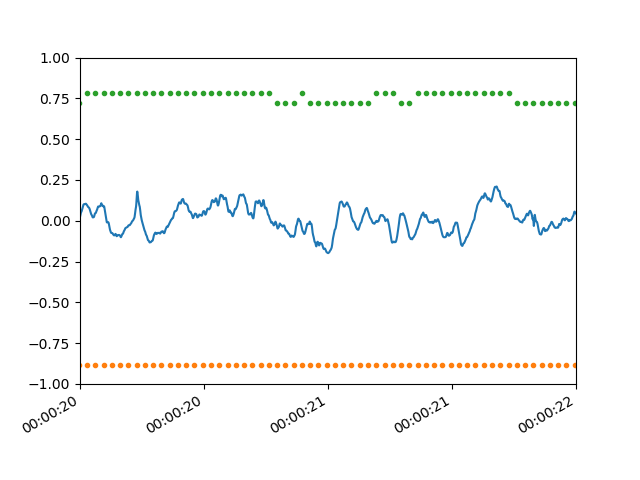

In [14]:
fig, ax = plt.subplots(1)
ax.plot(times, y)
ax.plot(mvmt_df['time'][y_conf_mask], y2[y_conf_mask], '.')
ax.plot(mvmt_df['time'][y_conf_mask], y3[y_conf_mask], '.')
# rotate and align the tick labels so they look better
plt.xlim([times[20*1000], times[22*1000]])
plt.ylim([-1,1])
fig.autofmt_xdate()

### Spectral analysis

We can examine the power spectrum of our filtered ECoG signal. We use Welch's method.

In [11]:
freq, Pxx = signal.welch(y, fs=f_sample, nperseg=4096)

<IPython.core.display.Javascript object>


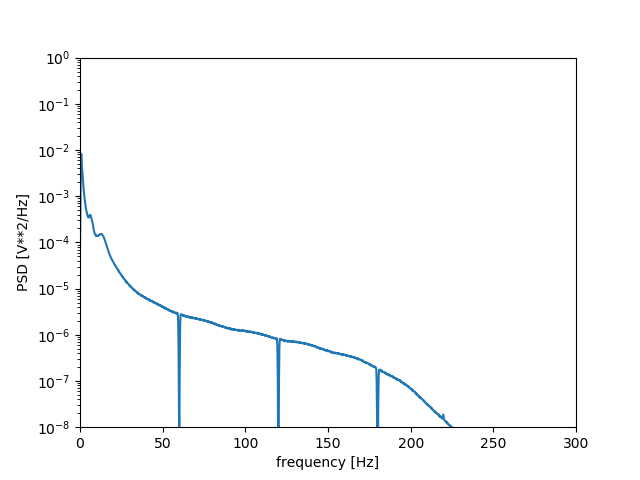

Text(0,0.5,'PSD [V**2/Hz]')

In [12]:
# Plot power spectral density
plt.figure()
plt.semilogy(freq, Pxx)
plt.xlim([0, f_high + 100])
plt.ylim([1e-8, 1])
plt.xlabel('frequency [Hz]')
plt.ylabel('PSD [V**2/Hz]')

We can see that the frequencies higher than 200 Hz are cutoff, and the line noise at 60, 120, and 180 Hz has been removed.

Finally, we should clean up our handle to f:

In [13]:
f._close()
del f